# Imports

In [1]:
import os
import sys
import re
import numpy as np
import pandas as pd
import json

In [2]:
from datetime import datetime, timedelta
import hashlib

In [3]:
sys.path.append('../')
sys.path.append('../src/')
sys.path.append('../spell/')

In [4]:
import EncodeCommand
import DeepLearningAnomalyDetection2

2024-09-16 13:08:09.486905: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-16 13:08:09.545937: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-16 13:08:10.325373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
from normal_utilities import *
from silent_utilities import *
from silent_utilities_2 import *
from preprocess_utilities import *

# Creation of datasets

## Normal execution

In [ ]:
fp = '../../../../../temp_logs/20240418/login01.laurel.log'
df = read(fp)
df_expanded = df['message'].apply(parse_audit_log).apply(pd.Series)
df = pd.concat([df, df_expanded], axis=1)
df.head()
df = preprocess_laurel(df)
save(df, fp + '.csv')

In [ ]:
normal_dataset_fp = fp + '.csv'
new_path = '../cleaned_data/normal.csv'
save(df, new_path)

## LinPeas noisy execution on laurel

In [ ]:
# First type of log file:
# laurel_anomalous_new
fp = '../data/laurel_anomalous_new/audit.log'
fps = [fp]
fps += [fp + f'.{str(i)}' for i in range(1,8)]
print(fps)

In [ ]:
for fp in fps:
    df = read(fp)
    df = preprocess_laurel(df)
    save(df, fp + '.csv')

## LinPeas silent execution on laurel

In [ ]:
# First type of log file:
# laurel_anomalous_new
fp = '../data/silent/audit.log'
fps = [fp]
fps += [fp + f'.{str(i)}' for i in range(1,11)]
print(fps)

In [ ]:
for fp in fps:
    df = read(fp)
    df = preprocess_laurel(df)
    save(df, fp + '.csv')

In [ ]:
import os

def concatenate_files(input_files, output_file):
    with open(output_file, 'w') as outfile:
        for filename in input_files:
            with open(filename, 'r') as infile:
                # Read each input file and write its content to the output file
                outfile.write(infile.read())
                outfile.write("\n")  # Optional: Adds a newline between files

# List of 10 input files (full paths or filenames)
input_files = ['../data/silent/audit.log', '../data/silent/audit.log.1', '../data/silent/audit.log.2', '../data/silent/audit.log.3', '../data/silent/audit.log.4', '../data/silent/audit.log.5', '../data/silent/audit.log.6', '../data/silent/audit.log.7', '../data/silent/audit.log.8', '../data/silent/audit.log.9', '../data/silent/audit.log.10']
input_files = input_files[::-1]
# Output file where the concatenated content will be written
output_file = 'silent.log'

# Call the function to concatenate the files
concatenate_files(input_files, output_file)

print(f"All files have been concatenated into {output_file}")

In [ ]:
# merge the csv files
fp = '../data/silent.log'
df = read(fp)
df = preprocess_laurel(df)
save(df, fp + '.csv')

# Preprocessing

## Data Reading

In [6]:
normal = pd.read_csv('../cleaned_data/normal.csv')
anomalous = pd.read_csv('../cleaned_data/anomalous0.csv')
silent = pd.read_csv('../cleaned_data/silent.log.csv')

In [7]:
encoder = EncodeCommand.EncodeCommand()
normal_ = preprocess(normal,encoder)
anomalous_ = preprocess(anomalous, encoder)
silent_ = preprocess(silent, encoder)

In [8]:
normal_.shape, anomalous_.shape, silent_.shape

((100000, 9), (1000, 9), (31006, 9))

In [9]:
normal_.head()

,exit,items,ppid,pid,timedelta,id_anomalies,num_id_anomalies,fp_length,enc_comm
0,0.0,2.0,0.781250,0.230469,0.000,0.0,0.0,0.0,1.0
1,0.0,3.0,0.636719,0.417969,1.862,0.0,8.0,0.0,2.0
2,0.0,0.0,0.539062,0.539062,0.002,0.0,0.0,0.0,3.0
3,0.0,0.0,0.539062,0.539062,0.006,0.0,0.0,0.0,3.0
4,0.0,0.0,0.539062,0.539062,0.001,0.0,0.0,0.0,3.0


In [10]:
anomalous_.head()

,exit,items,ppid,pid,timedelta,id_anomalies,num_id_anomalies,fp_length,enc_comm
0,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,0.0,54.0
1,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,0.0,54.0
2,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,0.0,54.0
3,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,0.0,54.0
4,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,0.0,54.0


In [11]:
silent_.head()

,exit,items,ppid,pid,timedelta,id_anomalies,num_id_anomalies,fp_length,enc_comm
0,0.0,2.0,0.449219,0.164062,0.000,0.0,0.0,0.0,1.0
1,0.0,2.0,0.449219,0.281250,0.007,0.0,0.0,0.0,1.0
2,0.0,2.0,0.449219,0.089844,0.019,0.0,0.0,0.0,1.0
3,0.0,2.0,0.449219,0.210938,-0.025,0.0,0.0,0.0,1.0
4,0.0,2.0,0.449219,0.335938,0.052,0.0,0.0,0.0,1.0


# Experiments and Results

## Statistics and ML

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [13]:
import ReduceDim
import ClusterData
import OneClass
import DetectAnomaly

### Clustering

#### Spell

#### Spell (Modified Edit Distance)

### Dimensionality Reduction

#### PCA, t-SNE, uMAP

In [14]:
# random sample of original dataset, done for feasibility
normal_reduced = normal_.sample(1000, random_state=42).reset_index(drop=True)
anomalous_reduced = anomalous_.sample(100, random_state=42).reset_index(drop=True)
silent_reduced = silent_.sample(100, random_state=42).reset_index(drop=True)

In [15]:
normal_reduced.head()

,exit,items,ppid,pid,timedelta,id_anomalies,num_id_anomalies,fp_length,enc_comm
0,0.0,2.0,0.085938,0.796875,0.001,0.0,0.0,0.0,52.0
1,0.0,2.0,0.085938,0.843750,0.004,0.0,0.0,0.0,69.0
2,0.0,2.0,0.152344,0.457031,0.001,0.0,0.0,0.0,52.0
3,0.0,2.0,0.085938,0.847656,0.001,0.0,0.0,0.0,52.0
4,0.0,2.0,0.218750,0.722656,0.001,0.0,8.0,0.0,5.0


In [16]:
r = ReduceDim.ReduceDim(3, normal_reduced, [0, 0])

pca_reduced_data = r.pca()
tsne_reduced_data = r.tsne()
umap_reduced_data = r.umap()

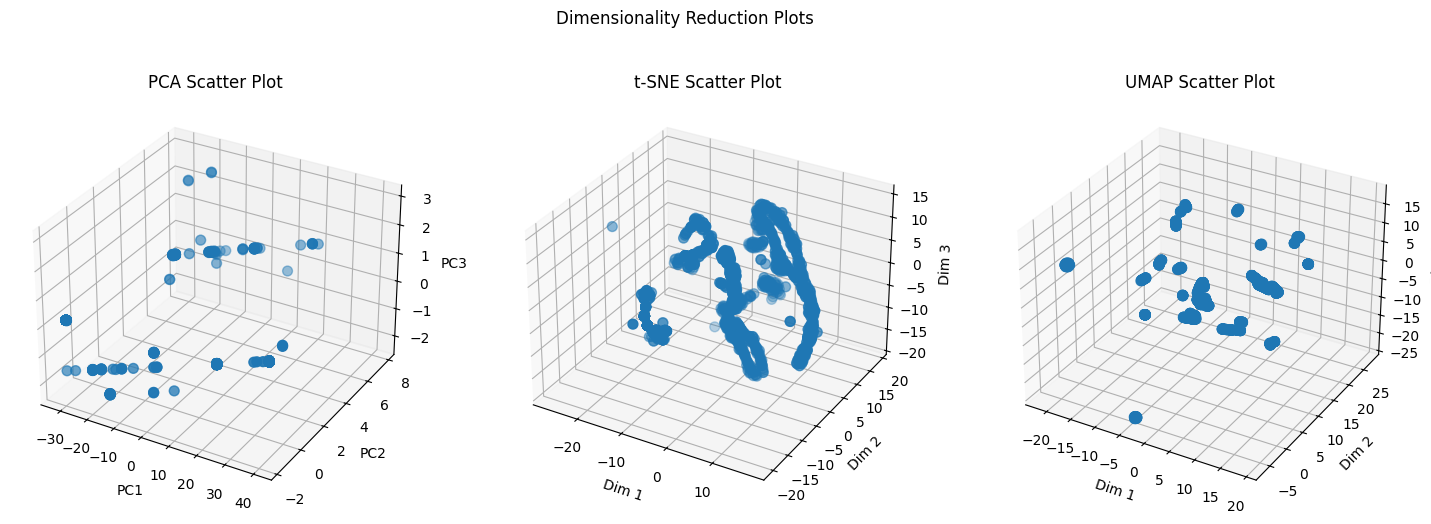

In [17]:
fig = plt.figure(figsize=(18, 6))
i = 0
# Plot PCA
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(pca_reduced_data[:, 0], pca_reduced_data[:, 1], pca_reduced_data[:, 2], s=50)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title(f'PCA Scatter Plot')

# Plot t-SNE
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(tsne_reduced_data[:, 0], tsne_reduced_data[:, 1], tsne_reduced_data[:, 2], s=50)
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_zlabel('Dim 3')
ax2.set_title(f't-SNE Scatter Plot')

# Plot UMAP
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(umap_reduced_data[:, 0], umap_reduced_data[:, 1], umap_reduced_data[:, 2], s=50)
ax3.set_xlabel('Dim 1')
ax3.set_ylabel('Dim 2')
ax3.set_zlabel('Dim 3')
ax3.set_title(f'UMAP Scatter Plot')

plt.suptitle(f'Dimensionality Reduction Plots')
plt.show()


### Anomaly Detection

#### Isolation Forest (normal vs anomalous)

In [18]:
# reduce with previous umap the anomalous data points
umap_anomalous = r.test_umap(anomalous_reduced)
umap_silent = r.test_umap(silent_reduced)

In [32]:
# creation of artificial anomaly data point
labels = np.concatenate([np.ones(umap_anomalous.shape[0]), np.zeros(umap_reduced_data.shape[0])])
new_data = np.vstack((umap_anomalous, umap_reduced_data))

labels_silent = np.concatenate([np.ones(umap_silent.shape[0]), np.zeros(umap_reduced_data.shape[0])])
new_data_silent = np.vstack((umap_silent, umap_reduced_data))

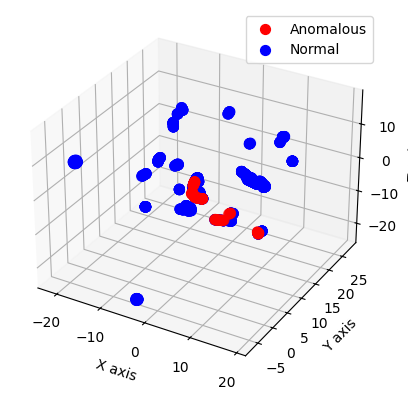

In [31]:
# 3D Scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot points, colored by label (1 for anomaly, 0 for normal)
ax.scatter(new_data[labels == 1][:, 0], new_data[labels == 1][:, 1], new_data[labels == 1][:, 2], 
           color='r', label='Anomalous', s=50)  # Red for anomalies

ax.scatter(new_data[labels == 0][:, 0], new_data[labels == 0][:, 1], new_data[labels == 0][:, 2], 
           color='b', label='Normal', s=50)  # Blue for normal points

# Add labels and legend
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show the plot
plt.show()

In [34]:
d = DetectAnomaly.DetectAnomaly(new_data, plots=[1,0])
anomaly_scores = d.isolation_forest()

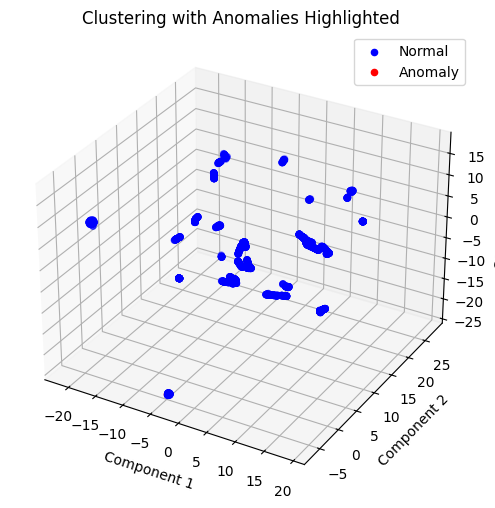

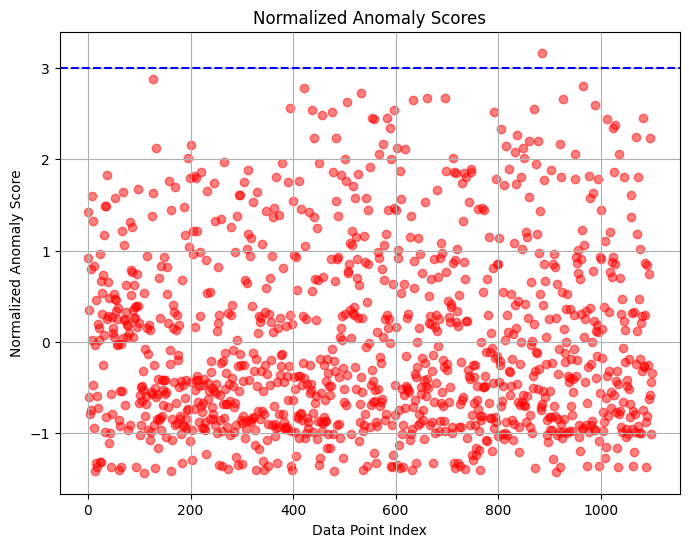

In [35]:
threshold = 0.03
anomaly_indices, anomaly_data_points = d.find_anomalies(anomaly_scores)

#### Isolation Forest (normal vs silent)

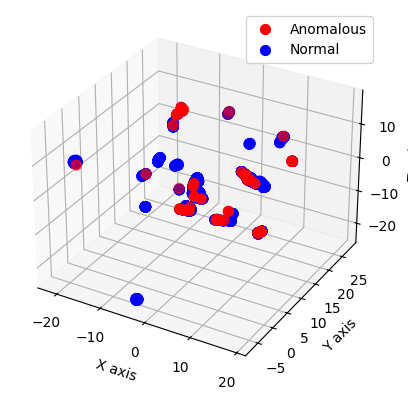

In [33]:
new_data = new_data_silent
labels = labels_silent

# 3D Scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot points, colored by label (1 for anomaly, 0 for normal)
ax.scatter(new_data[labels == 1][:, 0], new_data[labels == 1][:, 1], new_data[labels == 1][:, 2], 
           color='r', label='Anomalous', s=50)  # Red for anomalies

ax.scatter(new_data[labels == 0][:, 0], new_data[labels == 0][:, 1], new_data[labels == 0][:, 2], 
           color='b', label='Normal', s=50)  # Blue for normal points

# Add labels and legend
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show the plot
plt.show()

In [36]:
d = DetectAnomaly.DetectAnomaly(new_data, plots=[1,0])
anomaly_scores = d.isolation_forest()

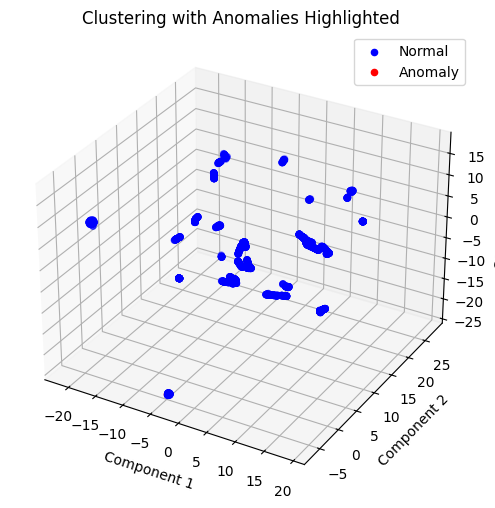

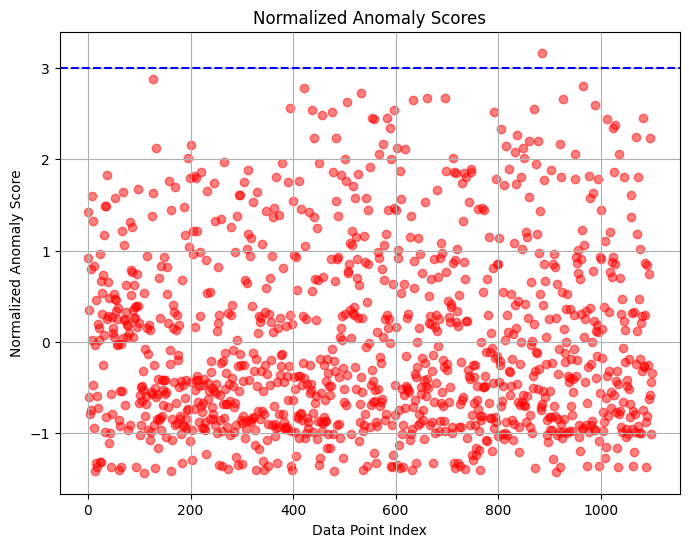

In [37]:
threshold = 0.03
anomaly_indices, anomaly_data_points = d.find_anomalies(anomaly_scores)

## DL Time Independent

### Normal vs Anomalous (secure)

In [ ]:
# see summary 6 to 9

### Normal vs Anomalous (laurel)

Mean normal reconstruction error: 0.01499112094235114
Mean anomalous reconstruction error: 0.03699694298280672


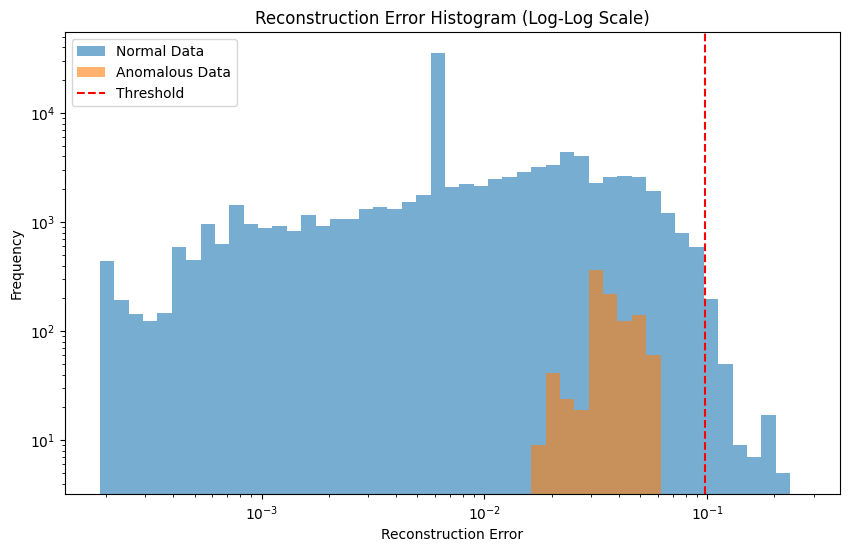

Threshold for anomaly detection: 0.09812170245322219
Number of anomalies detected: 0
Number of false positives detected: 250


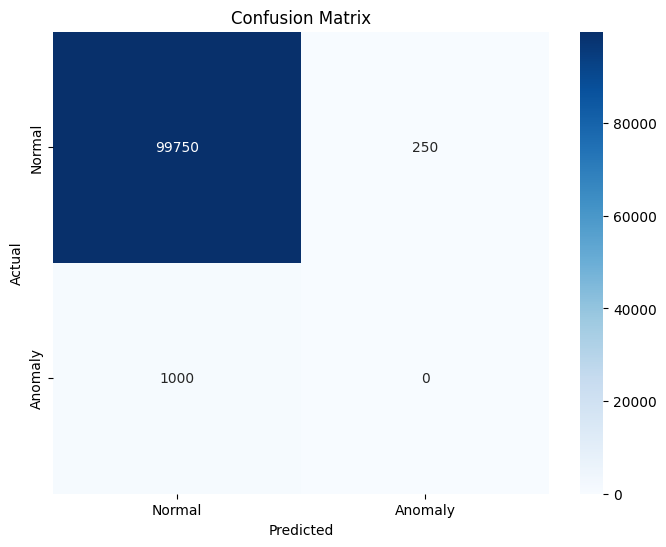

In [38]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(normal_, anomalous_, 'autoencoder', laurel=1, plots=[0,0,1,1])

### Normal vs Silent (laurel)

Mean normal reconstruction error: 0.0089816216930396
Mean anomalous reconstruction error: 227551.41421392027


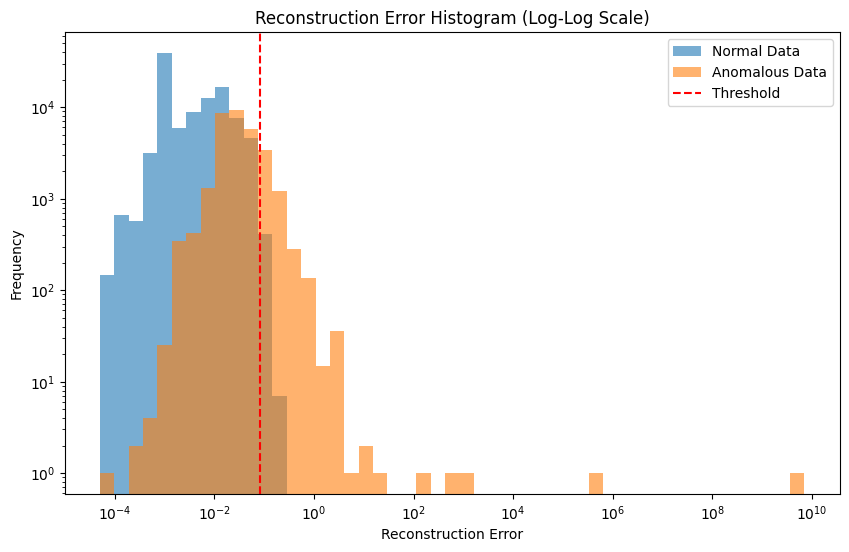

Threshold for anomaly detection: 0.08397678434146842
Number of anomalies detected: 4836
Number of false positives detected: 250


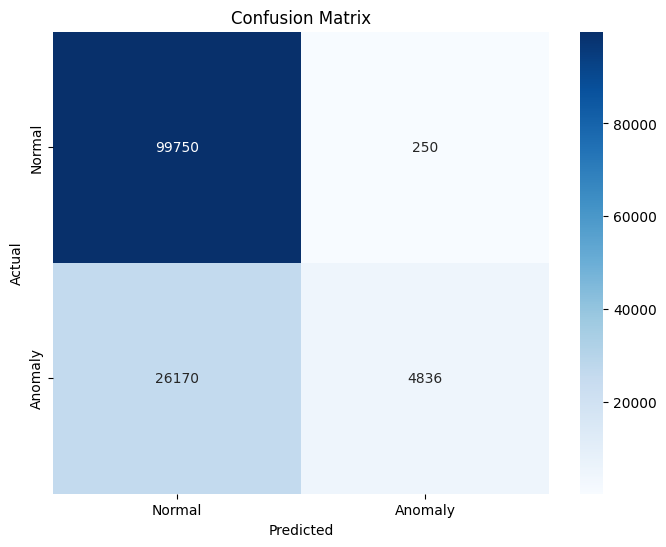

In [39]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(normal_, silent_, 'autoencoder', laurel=1, plots=[0,0,1,1])

In [40]:
# remove features
normal_small = normal_.drop(['pid', 'ppid'], axis=1)
silent_small = silent_.drop(['pid', 'ppid'], axis=1)

Mean normal reconstruction error: 0.00022698968015582593
Mean anomalous reconstruction error: 292564.23281843215


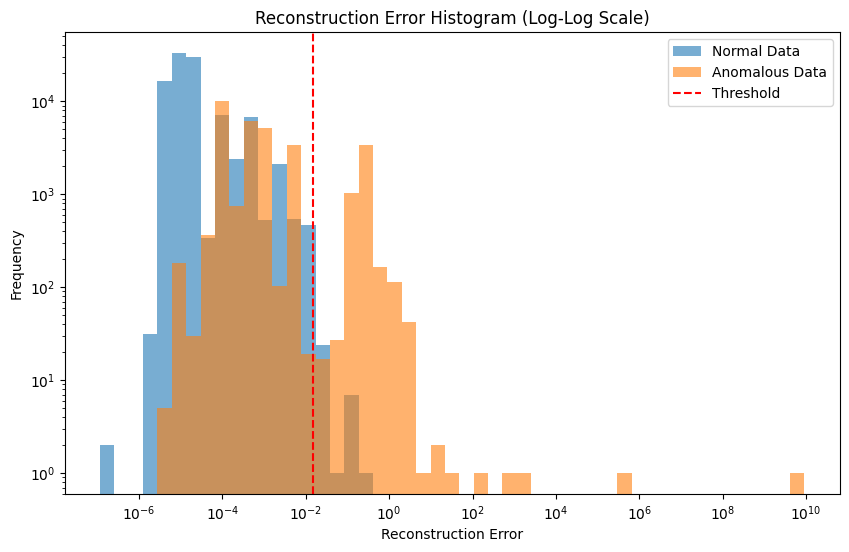

Threshold for anomaly detection: 0.014646855427975464
Number of anomalies detected: 4802
Number of false positives detected: 59


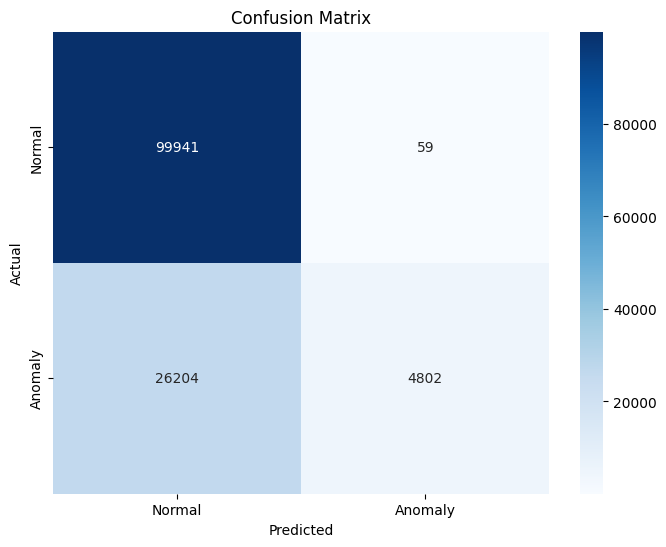

In [41]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(normal_small, silent_small, 'autoencoder', laurel=1, plots=[0,0,1,1])

## DL Time Dependent

In [ ]:
# to complete